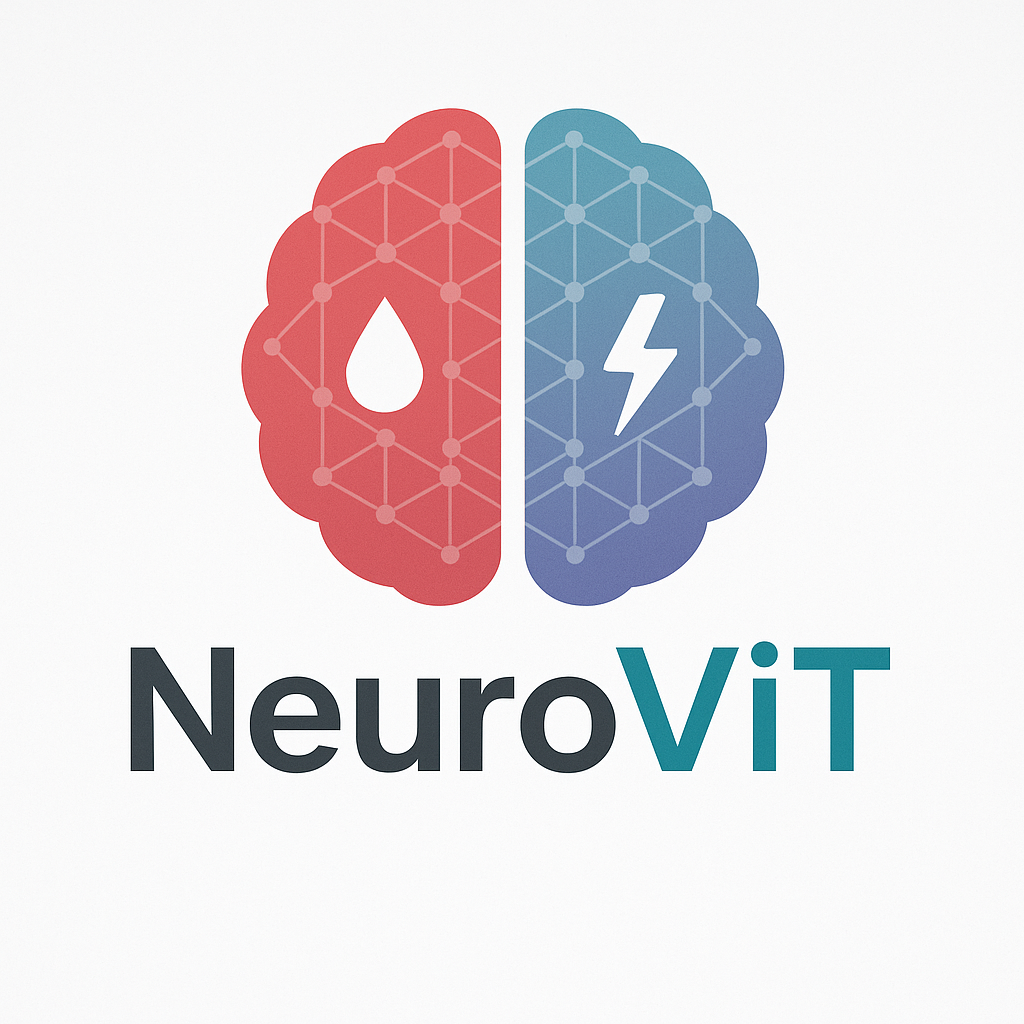



# ✨ **Developed By** ✨

---

### 🚀 **Team Members** 🚀  
| **Name**                | **Title**               |  
|-------------------------|-------------------------|  
| `Engr. Muhammad Osama`  | *Lead Developer*        |  
| `Muneeb Ur Rehman`      | *Creative Architect*    |  
| `Muhammad Moeez`        | *Systems Support*      |  

---

🔧 **Powered by Innovation** | 🌟 **Crafted with Excellence**  

# 🧠 NeuroViT: Vision Transformer for Image Classification

This notebook demonstrates how to fine-tune a Vision Transformer (ViT) model using the Hugging Face `transformers` library for image classification tasks.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTModel, ViTConfig
from transformers import ViTForImageClassification, ViTImageProcessor
from datasets import load_dataset
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 1. Load and prepare dataset
def load_and_split_dataset(test_size=0.2, val_size=0.1):
    """Load dataset and split into train/val/test sets while maintaining original format"""
    # Load dataset (only has 'train' split)
    dataset = load_dataset("BTX24/tekno21-brain-stroke-dataset-binary")['train']

    # First split: train + temp (test + val)
    train_size = int((1 - test_size - val_size) * len(dataset))
    temp_size = len(dataset) - train_size

    # Use torch's random_split to maintain original dataset structure
    train_ds, temp_ds = random_split(
        dataset,
        [train_size, temp_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Second split: test and validation from temp
    val_ratio = val_size / (test_size + val_size)
    val_size = int(val_ratio * len(temp_ds))
    test_size = len(temp_ds) - val_size

    val_ds, test_ds = random_split(
        temp_ds,
        [val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    return train_ds, val_ds, test_ds

In [ ]:
# 2. Custom Dataset Class
class StrokeDataset(Dataset):
    """Custom dataset that handles both original and split datasets"""
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'].convert('RGB')

        label = item['label']
        if isinstance(label, str):
            label = 1 if label == 'inme var' else 0
        else:
            label = int(label)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [ ]:
# 4. Load and split data
train_ds, val_ds, test_ds = load_and_split_dataset()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/288M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7369 [00:00<?, ? examples/s]

In [ ]:
# 7. Training loop with validation
def generic_train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs, model_name="Model"):
    """Generic training loop with validation"""
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    print(f"\n--- Training {model_name} ---")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0

        progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [{model_name} Train]')
        for images, labels in progress_bar_train:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if hasattr(outputs, 'logits')
                outputs = outputs.logits

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar_train.set_postfix({
                'loss': epoch_train_loss/(progress_bar_train.n+1), # loss per batch
                'acc': 100*correct_train/total_train
            })

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [{model_name} Val]')
            for images, labels in progress_bar_val:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                if hasattr(outputs, 'logits'):
                    outputs = outputs.logits

                epoch_val_loss += loss_fn(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                progress_bar_val.set_postfix({
                    'loss': epoch_val_loss/(progress_bar_val.n+1),
                    'acc': 100*correct_val/total_val
                })


        # Calculate metrics
        avg_train_loss = epoch_train_loss/len(train_loader)
        avg_train_acc = 100*correct_train/total_train
        avg_val_loss = epoch_val_loss/len(val_loader)
        avg_val_acc = 100*correct_val/total_val

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)

        print(f'\nEpoch {epoch+1} Summary for {model_name}:')
        print(f'Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}   | Val Acc: {avg_val_acc:.2f}%')

    return train_losses, val_losses, train_accs, val_accs


def generic_evaluate_model(model, test_loader, device, loss_fn, id2label, model_name="Model"):
    print(f"\n--- Evaluating {model_name} on the test set ---")
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    all_labels_list = []
    all_predictions_list = []

    with torch.no_grad():
        progress_bar_test = tqdm(test_loader, desc=f'{model_name} Test Evaluation')
        for images, labels in progress_bar_test:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_labels_list.extend(labels.cpu().numpy())
            all_predictions_list.extend(predicted.cpu().numpy())

            progress_bar_test.set_postfix({
                'loss': test_loss/(progress_bar_test.n+1),
                'acc': 100*correct_test/total_test
            })

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    print(f'\n{model_name} Test Loss: {avg_test_loss:.4f}')
    print(f'{model_name} Test Accuracy: {test_accuracy:.2f}%')

    print("\nClassification Report:")
    target_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(all_labels_list, all_predictions_list, target_names=target_names, digits=4))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels_list, all_predictions_list)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return avg_test_loss, test_accuracy, all_labels_list, all_predictions_list

id2label_map = {0: 'inme yok', 1: 'inme var'}

print("Generic training and evaluation functions defined.")

Generic training and evaluation functions defined.


In [ ]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs, model_name="Model"):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'{model_name} Train Loss')
    plt.plot(val_losses, label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label=f'{model_name} Train Accuracy')
    plt.plot(val_accs, label=f'{model_name} Validation Accuracy')
    plt.title(f'{model_name} Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

---

# Baseline model

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms as T

# Define transformations for ResNet18
# Standard ImageNet normalization
resnet_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("ResNet18 transformations defined.")

ResNet18 transformations defined.


In [ ]:
train_dataset_resnet = StrokeDataset(train_ds, transform=resnet_transform)
val_dataset_resnet = StrokeDataset(val_ds, transform=resnet_transform)
test_dataset_resnet = StrokeDataset(test_ds, transform=resnet_transform)

# Create dataloaders for ResNet
batch_size = 16
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=batch_size)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=batch_size)

print(f"DataLoaders for ResNet18 created. Training samples: {len(train_dataset_resnet)}, Validation samples: {len(val_dataset_resnet)}, Test samples: {len(test_dataset_resnet)}")

DataLoaders for ResNet18 created. Training samples: 5158, Validation samples: 737, Test samples: 1474


In [ ]:
# Initialize ResNet18 model
baseline_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer for 2 classes
num_ftrs = baseline_model.fc.in_features
baseline_model.fc = nn.Linear(num_ftrs, 2) # 2 output classes: 'inme yok', 'inme var'

baseline_model = baseline_model.to(device)

print("ResNet18 baseline model initialized and moved to device.")
print(baseline_model.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.6MB/s]


ResNet18 baseline model initialized and moved to device.
Linear(in_features=512, out_features=2, bias=True)


In [ ]:
optimizer_baseline = torch.optim.AdamW(baseline_model.parameters(), lr=1e-4, weight_decay=0.01)

criterion_baseline = nn.CrossEntropyLoss()

print("Optimizer and criterion for ResNet18 baseline defined.")

Optimizer and criterion for ResNet18 baseline defined.


In [ ]:
num_epochs_baseline = 15

baseline_train_losses, baseline_val_losses, baseline_train_accs, baseline_val_accs = generic_train_model(
    model=baseline_model,
    train_loader=train_loader_resnet,
    val_loader=val_loader_resnet,
    optimizer=optimizer_baseline,
    loss_fn=criterion_baseline,
    device=device,
    num_epochs=num_epochs_baseline,
    model_name="ResNet18_Baseline"
)


--- Training ResNet18_Baseline ---


Epoch 1/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:05<00:00,  8.18it/s, loss=0.233, acc=90.8]



Epoch 1 Summary for ResNet18_Baseline:
Train Loss: 0.3161 | Train Acc: 86.76%
Val Loss: 0.2329   | Val Acc: 90.77%


Epoch 2/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:05<00:00,  8.48it/s, loss=0.0899, acc=96.7]



Epoch 2 Summary for ResNet18_Baseline:
Train Loss: 0.1412 | Train Acc: 94.82%
Val Loss: 0.0899   | Val Acc: 96.74%


Epoch 3/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:06<00:00,  7.51it/s, loss=0.0804, acc=96.6]



Epoch 3 Summary for ResNet18_Baseline:
Train Loss: 0.0865 | Train Acc: 96.86%
Val Loss: 0.0804   | Val Acc: 96.61%


Epoch 4/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:05<00:00,  8.16it/s, loss=0.106, acc=96.5]



Epoch 4 Summary for ResNet18_Baseline:
Train Loss: 0.0523 | Train Acc: 98.20%
Val Loss: 0.1064   | Val Acc: 96.47%


Epoch 5/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:05<00:00,  8.50it/s, loss=0.13, acc=95.8]



Epoch 5 Summary for ResNet18_Baseline:
Train Loss: 0.0496 | Train Acc: 98.27%
Val Loss: 0.1295   | Val Acc: 95.79%


Epoch 6/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:06<00:00,  7.53it/s, loss=0.0598, acc=97.7]



Epoch 6 Summary for ResNet18_Baseline:
Train Loss: 0.0473 | Train Acc: 98.37%
Val Loss: 0.0598   | Val Acc: 97.69%


Epoch 7/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:05<00:00,  7.93it/s, loss=0.0645, acc=97.3]



Epoch 7 Summary for ResNet18_Baseline:
Train Loss: 0.0388 | Train Acc: 98.76%
Val Loss: 0.0645   | Val Acc: 97.29%


Epoch 8/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:05<00:00,  8.51it/s, loss=0.0717, acc=97.7]



Epoch 8 Summary for ResNet18_Baseline:
Train Loss: 0.0136 | Train Acc: 99.65%
Val Loss: 0.0717   | Val Acc: 97.69%


Epoch 9/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, loss=0.0503, acc=98.6]



Epoch 9 Summary for ResNet18_Baseline:
Train Loss: 0.0177 | Train Acc: 99.48%
Val Loss: 0.0503   | Val Acc: 98.64%


Epoch 10/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:06<00:00,  6.72it/s, loss=0.149, acc=94.3]



Epoch 10 Summary for ResNet18_Baseline:
Train Loss: 0.0208 | Train Acc: 99.36%
Val Loss: 0.1491   | Val Acc: 94.30%


Epoch 11/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:07<00:00,  6.35it/s, loss=0.113, acc=95.9]



Epoch 11 Summary for ResNet18_Baseline:
Train Loss: 0.0362 | Train Acc: 98.78%
Val Loss: 0.1128   | Val Acc: 95.93%


Epoch 12/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:05<00:00,  7.98it/s, loss=0.106, acc=96.6]



Epoch 12 Summary for ResNet18_Baseline:
Train Loss: 0.0196 | Train Acc: 99.36%
Val Loss: 0.1064   | Val Acc: 96.61%


Epoch 13/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:06<00:00,  6.77it/s, loss=0.079, acc=97]



Epoch 13 Summary for ResNet18_Baseline:
Train Loss: 0.0216 | Train Acc: 99.42%
Val Loss: 0.0790   | Val Acc: 97.01%


Epoch 14/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:06<00:00,  7.58it/s, loss=0.11, acc=96.9]



Epoch 14 Summary for ResNet18_Baseline:
Train Loss: 0.0130 | Train Acc: 99.55%
Val Loss: 0.1101   | Val Acc: 96.88%


Epoch 15/15 [ResNet18_Baseline Val]: 100%|██████████| 47/47 [00:05<00:00,  8.26it/s, loss=0.0521, acc=98]


Epoch 15 Summary for ResNet18_Baseline:
Train Loss: 0.0340 | Train Acc: 99.11%
Val Loss: 0.0521   | Val Acc: 97.96%


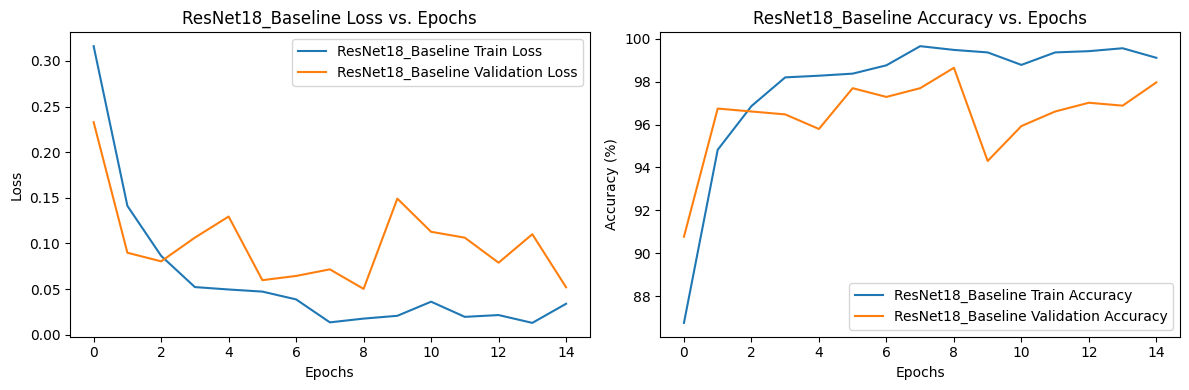

In [ ]:
# Plot for ResNet18 Baseline
plot_training_history(baseline_train_losses, baseline_val_losses, baseline_train_accs, baseline_val_accs, "ResNet18_Baseline")


--- Evaluating ResNet18_Baseline on the test set ---


ResNet18_Baseline Test Evaluation: 100%|██████████| 93/93 [00:12<00:00,  7.34it/s, loss=0.112, acc=96.7]



ResNet18_Baseline Test Loss: 0.1118
ResNet18_Baseline Test Accuracy: 96.74%

Classification Report:
              precision    recall  f1-score   support

    inme yok     0.9872    0.9292    0.9573       579
    inme var     0.9559    0.9922    0.9737       895

    accuracy                         0.9674      1474
   macro avg     0.9715    0.9607    0.9655      1474
weighted avg     0.9682    0.9674    0.9672      1474


Confusion Matrix:


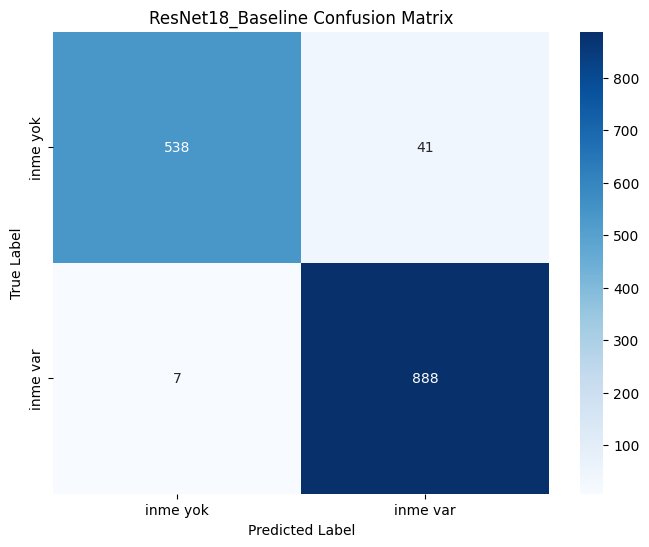

In [ ]:
avg_test_loss_baseline, test_accuracy_baseline, _, _ = generic_evaluate_model(
    model=baseline_model,
    test_loader=test_loader_resnet,
    device=device,
    loss_fn=criterion_baseline,
    id2label=id2label_map,
    model_name="ResNet18_Baseline"
)

---

# Advance model

In [ ]:
# 3. Initialize ViT processor and transformations
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

def vit_transform(image):
    """Transform image for ViT model using HuggingFace processor"""
    return processor(image, return_tensors="pt")['pixel_values'].squeeze(0)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512>,
 'label': 1}

In [ ]:
# Create dataset objects
train_dataset = StrokeDataset(train_ds, transform=vit_transform)
val_dataset = StrokeDataset(val_ds, transform=vit_transform)
test_dataset = StrokeDataset(test_ds, transform=vit_transform)

In [ ]:
# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# 5. Model initialization with proper classification head
print("Initializing model with custom classification head...")

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=2,
    id2label={0: 'inme yok', 1: 'inme var'},
    label2id={'inme yok': 0, 'inme var': 1},
    ignore_mismatched_sizes=True
)

with torch.no_grad():
    nn.init.kaiming_normal_(model.classifier.weight, mode='fan_out', nonlinearity='relu')
    nn.init.constant_(model.classifier.bias, 0)

model = model.to(device)

print(f"Model initialized. Moving to {device}...")
print(f"Classification head weights: {model.classifier.weight.shape}")
print(f"Classification head bias: {model.classifier.bias.shape}")

Initializing model with custom classification head...


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized. Moving to cuda...
Classification head weights: torch.Size([2, 768])
Classification head bias: torch.Size([2])


In [ ]:
# Configure training parameters
def configure_optimizer(model):

    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if 'classifier' in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = torch.optim.AdamW([
        {'params': backbone_params, 'lr': 5e-5},
        {'params': head_params, 'lr': 1e-4}
    ], weight_decay=0.01)

    return optimizer

optimizer_vit = configure_optimizer(model)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 15

In [ ]:
# Run training
print("\n--- Training ViT (Advanced Model) ---")
vit_train_losses, vit_val_losses, vit_train_accs, vit_val_accs = generic_train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_vit,
    loss_fn=loss_fn,
    device=device,
    num_epochs=num_epochs,
    model_name="ViT_Advanced"
)


--- Training ViT (Advanced Model) ---

--- Training ViT_Advanced ---


Epoch 1/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s, loss=0.255, acc=90.1]



Epoch 1 Summary for ViT_Advanced:
Train Loss: 0.3477 | Train Acc: 86.08%
Val Loss: 0.2553   | Val Acc: 90.09%


Epoch 2/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s, loss=0.187, acc=92.4]



Epoch 2 Summary for ViT_Advanced:
Train Loss: 0.1155 | Train Acc: 95.79%
Val Loss: 0.1875   | Val Acc: 92.40%


Epoch 3/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.55it/s, loss=0.155, acc=95]



Epoch 3 Summary for ViT_Advanced:
Train Loss: 0.0452 | Train Acc: 98.53%
Val Loss: 0.1550   | Val Acc: 94.98%


Epoch 4/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.50it/s, loss=0.164, acc=95.8]



Epoch 4 Summary for ViT_Advanced:
Train Loss: 0.0602 | Train Acc: 97.93%
Val Loss: 0.1637   | Val Acc: 95.79%


Epoch 5/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.49it/s, loss=0.126, acc=95.4]



Epoch 5 Summary for ViT_Advanced:
Train Loss: 0.0290 | Train Acc: 98.93%
Val Loss: 0.1263   | Val Acc: 95.39%


Epoch 6/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.53it/s, loss=0.296, acc=94.3]



Epoch 6 Summary for ViT_Advanced:
Train Loss: 0.0199 | Train Acc: 99.26%
Val Loss: 0.2958   | Val Acc: 94.30%


Epoch 7/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.53it/s, loss=0.158, acc=95.7]



Epoch 7 Summary for ViT_Advanced:
Train Loss: 0.0171 | Train Acc: 99.36%
Val Loss: 0.1578   | Val Acc: 95.66%


Epoch 8/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.55it/s, loss=0.213, acc=95.9]



Epoch 8 Summary for ViT_Advanced:
Train Loss: 0.0095 | Train Acc: 99.69%
Val Loss: 0.2135   | Val Acc: 95.93%


Epoch 9/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s, loss=0.0917, acc=97.6]



Epoch 9 Summary for ViT_Advanced:
Train Loss: 0.0470 | Train Acc: 98.62%
Val Loss: 0.0917   | Val Acc: 97.56%


Epoch 10/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s, loss=0.138, acc=96.6]



Epoch 10 Summary for ViT_Advanced:
Train Loss: 0.0152 | Train Acc: 99.57%
Val Loss: 0.1380   | Val Acc: 96.61%


Epoch 11/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s, loss=0.151, acc=96.6]



Epoch 11 Summary for ViT_Advanced:
Train Loss: 0.0149 | Train Acc: 99.46%
Val Loss: 0.1506   | Val Acc: 96.61%


Epoch 12/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.43it/s, loss=0.114, acc=96.5]



Epoch 12 Summary for ViT_Advanced:
Train Loss: 0.0311 | Train Acc: 99.01%
Val Loss: 0.1138   | Val Acc: 96.47%


Epoch 13/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.38it/s, loss=0.164, acc=96.5]



Epoch 13 Summary for ViT_Advanced:
Train Loss: 0.0056 | Train Acc: 99.79%
Val Loss: 0.1638   | Val Acc: 96.47%


Epoch 14/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.50it/s, loss=0.231, acc=92.8]



Epoch 14 Summary for ViT_Advanced:
Train Loss: 0.0224 | Train Acc: 99.52%
Val Loss: 0.2307   | Val Acc: 92.81%


Epoch 15/15 [ViT_Advanced Val]: 100%|██████████| 47/47 [00:13<00:00,  3.50it/s, loss=0.151, acc=95.7]


Epoch 15 Summary for ViT_Advanced:
Train Loss: 0.0250 | Train Acc: 99.13%
Val Loss: 0.1513   | Val Acc: 95.66%


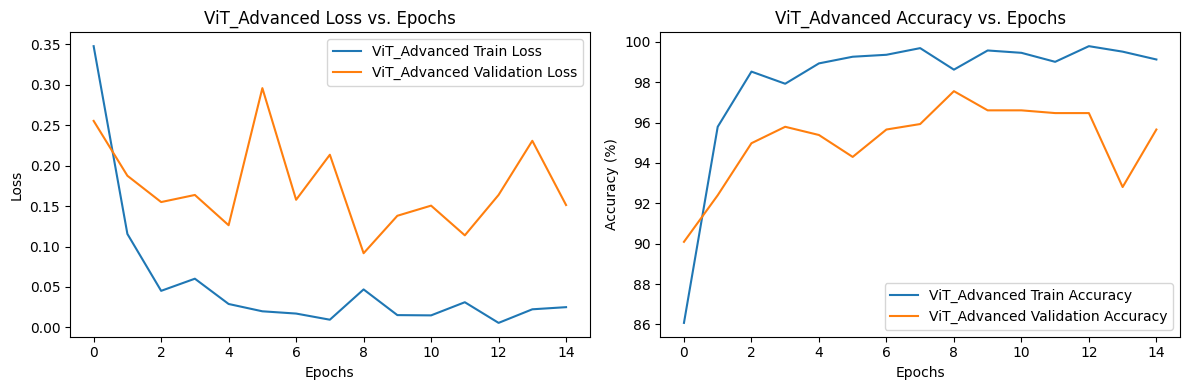

In [ ]:
# 8. Plot Training and Validation Metrics
plot_training_history(vit_train_losses, vit_val_losses, vit_train_accs, vit_val_accs, "ViT_Advanced")


--- Evaluating ViT_Advanced on the test set ---


ViT_Advanced Test Evaluation: 100%|██████████| 93/93 [00:26<00:00,  3.51it/s, loss=0.23, acc=94.7]



ViT_Advanced Test Loss: 0.2298
ViT_Advanced Test Accuracy: 94.71%

Classification Report:
              precision    recall  f1-score   support

    inme yok     0.9196    0.9482    0.9337       579
    inme var     0.9658    0.9464    0.9560       895

    accuracy                         0.9471      1474
   macro avg     0.9427    0.9473    0.9448      1474
weighted avg     0.9476    0.9471    0.9472      1474


Confusion Matrix:


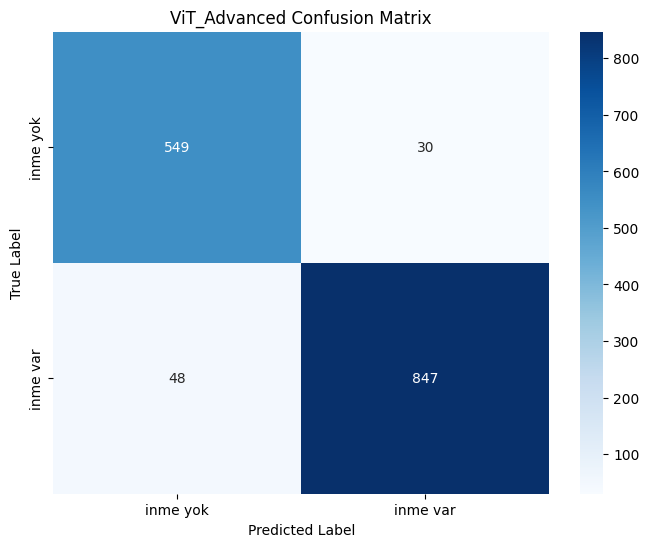

In [ ]:
# 9. Evaluate the Model on the Test Set
avg_test_loss_vit, test_accuracy_vit, _, _ = generic_evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device,
    loss_fn=loss_fn,
    id2label=model.config.id2label,
    model_name="ViT_Advanced"
)